<a href="https://colab.research.google.com/github/FadyEhab-coder/ML-Projects/blob/main/detect_hate_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import numpy as np #-> basic data operations
import pandas as pd
import seaborn as sns #->c bonds,used in confusion matrix
import matplotlib.pyplot as plt #-> visulize the data
%matplotlib inline
from matplotlib import style #-> setting the style using the style function
style.use('ggplot') #-> set the style ggplot
import string
import nltk
from nltk.tokenize import word_tokenize #-> to perform word tokenization
from nltk.corpus import stopwords #-> to perform wordstop
stop_words = set(stopwords.words('english')) #-> set the language as english for our stopword
from nltk.util import pr
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet #-> used in POS 'n,v,adj,etc'
import re #->regex functions used in data cleaning
from nltk.corpus import brown
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix #->for confusion matrix

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,accuracy_score #->for our results--to print report,acc,display confusionMAtrix'
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from time import time


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Dataset

In [ ]:
dataset = pd.read_csv(r"D:\universty.cs\fady project\finalproject\dataset\labeled_data.csv")

In [ ]:
# Adding text-length as a field in the dataset
dataset['text length'] = dataset['tweet'].apply(len)
print(dataset.head())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  text length  
0  !!! RT @mayasolovely: As a woman you shouldn't...          140  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...           85  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...          120  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...           62  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...          137  


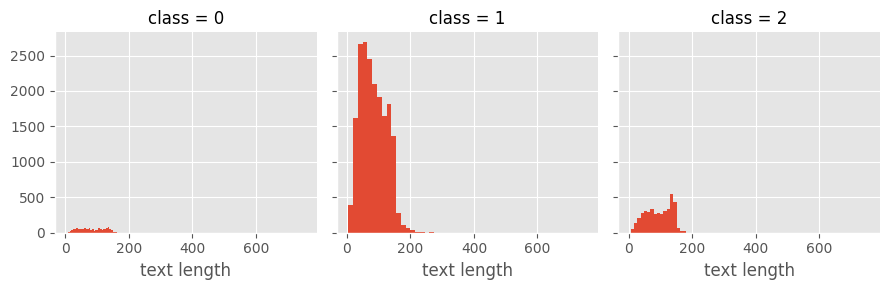

In [ ]:
#Basic visualization of data using histograms
# FacetGrid- Multi-plot grid for plotting conditional relationships
graph = sns.FacetGrid(data=dataset, col='class')
graph.map(plt.hist, 'text length', bins=50)

<Axes: xlabel='class', ylabel='text length'>

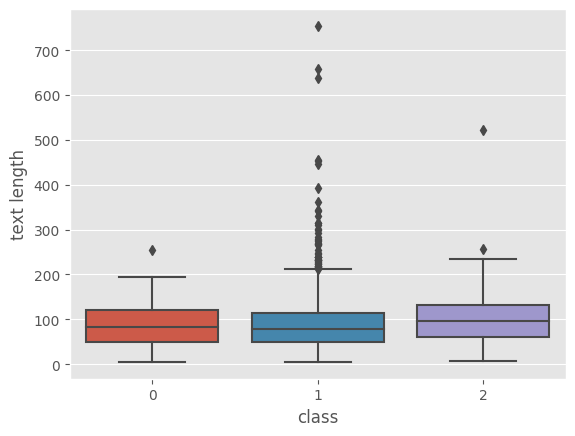

In [ ]:
# Box-plot visvualization
sns.boxplot(x='class', y='text length', data=dataset)
#From the box-plot, looks like the class-1 tweets have much longer text s0 so text-length won’t be a useful feature to consider#

<Axes: >

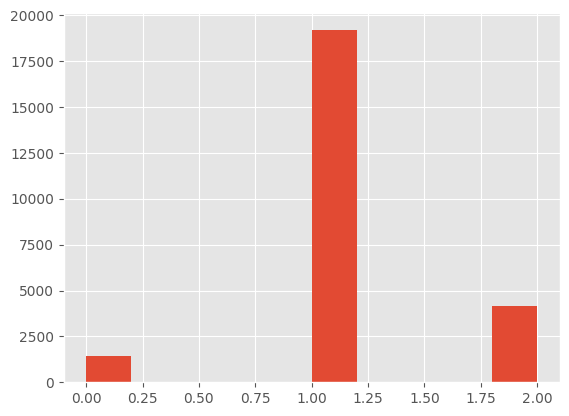

In [ ]:
dataset['class'].hist()
## histogram shows that most of the tweets are considered to be offensive words by the CF coders##

In [ ]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=dataset.tweet

# Data Preprocessing

In [ ]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(tweet):

    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')

    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()

    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())

    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])

    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet

    return tweets_p

#remove emoji
def remove_special_characters(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
processed_tweets = preprocess(tweet)

dataset['processed_tweets'] = processed_tweets

print(dataset[["processed_tweets"]].head(10))

                                    processed_tweets
0  woman complain clean hous amp man alway take t...
1  boy dat cold tyga dwn bad cuffin dat hoe st place
2         dawg ever fuck bitch start cri confus shit
3                                   look like tranni
4     shit hear might true might faker bitch told ya
5      shit blow claim faith somebodi still fuck hoe
6              sit hate anoth bitch got much shit go
7            caus tire big bitch come us skinni girl
8               amp might get ya bitch back amp that
9                    hobbi includ fight mariam bitch


In [ ]:
dataset['tokenized'] = dataset['processed_tweets'].apply(word_tokenize)
dataset.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,text length,processed_tweets,tokenized
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,140,woman complain clean hous amp man alway take t...,"[woman, complain, clean, hous, amp, man, alway..."
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,85,boy dat cold tyga dwn bad cuffin dat hoe st place,"[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ..."
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,120,dawg ever fuck bitch start cri confus shit,"[dawg, ever, fuck, bitch, start, cri, confus, ..."
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,62,look like tranni,"[look, like, tranni]"
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,137,shit hear might true might faker bitch told ya,"[shit, hear, might, true, might, faker, bitch,..."


In [ ]:
checkpoint = modelcheckpoint ("project_text.h5",monitor ='loss',verbose=1,save_best_only=True)
model.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.001),metrics=["accuracy_score"])
history =model.fit(x,y,epochs=33,batch_size=64,callback=[checkpoint])

In [ ]:
#POS
wordnet_map = {"N":wordnet.NOUN,
               "V":wordnet.VERB,
               "J":wordnet.ADJ,
               "R":wordnet.ADV
              }

train_sents = brown.tagged_sents(categories='news')
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)

def pos_tag_wordnet(text, pos_tag_type="pos_tag"):
    """
        Create pos_tag with wordnet format
    """
    pos_tagged_text = t2.tag(text)

    # map the pos tagging output with wordnet output
    pos_tagged_text = [(word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() else (word, wordnet.NOUN) for (word, pos_tag) in pos_tagged_text ]
    return pos_tagged_text

pos_tag_wordnet(dataset['tokenized'][2])

dataset['combined_postag_wnet'] = dataset['tokenized'].apply(lambda x: pos_tag_wordnet(x))
dataset.head()

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - 'C:\\Users\\Vertex/nltk_data'
    - 'c:\\Users\\Vertex\\AppData\\Local\\Programs\\Python\\Python311\\nltk_data'
    - 'c:\\Users\\Vertex\\AppData\\Local\\Programs\\Python\\Python311\\share\\nltk_data'
    - 'c:\\Users\\Vertex\\AppData\\Local\\Programs\\Python\\Python311\\lib\\nltk_data'
    - 'C:\\Users\\Vertex\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [ ]:
def lemmatize_word(text):

    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemma

lemmatizer = WordNetLemmatizer()

dataset['lemmatize_word_w_pos'] = dataset['combined_postag_wnet'].apply(lambda x: lemmatize_word(x))
# double check to remove stop words
dataset['lemmatize_text'] = [' '.join(map(str, l)) for l in dataset['lemmatize_word_w_pos']] # join back to text

dataset.head()

KeyError: 'combined_postag_wnet'

# Feature Extraction

In [ ]:
#TF-IDF Features-F1
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )
tfidf

<24783x6441 sparse matrix of type '<class 'numpy.float64'>'
	with 189618 stored elements in Compressed Sparse Row format>

## Running various model Using TFIDF without additional features

In [ ]:
# If you don't specify the random_state in the code,
# then every time you run(execute) your code a new random value is generated
# and the train and test datasets would have different values each time

X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

#RF
rf=RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc1=accuracy_score(y_test,y_preds)
precision1=accuracy_score(y_test,y_preds)
recall1 = recall_score(y_test,y_preds, average='weighted')
f1 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds)
print(report)
print("Random Forest, Accuracy Score:",acc1,"-> {:.2f}%".format(acc1*100))
print("Random Forest, pre Score:",precision1,"-> {:.2f}%".format(precision1*100))
print("Random Forest, recall Score:",recall1,"-> {:.2f}%".format(recall1*100))
print("Random Forest, f1-score:",f1,"-> {:.2f}%".format(f1*100))

              precision    recall  f1-score   support

           0       0.49      0.15      0.23       290
           1       0.93      0.96      0.94      3832
           2       0.83      0.91      0.87       835

    accuracy                           0.90      4957
   macro avg       0.75      0.67      0.68      4957
weighted avg       0.89      0.90      0.89      4957

Random Forest, Accuracy Score: 0.9023602985676821 -> 90.24%
Random Forest, pre Score: 0.9023602985676821 -> 90.24%
Random Forest, recall Score: 0.9023602985676821 -> 90.24%
Random Forest, f1-score: 0.8883736798492081 -> 88.84%


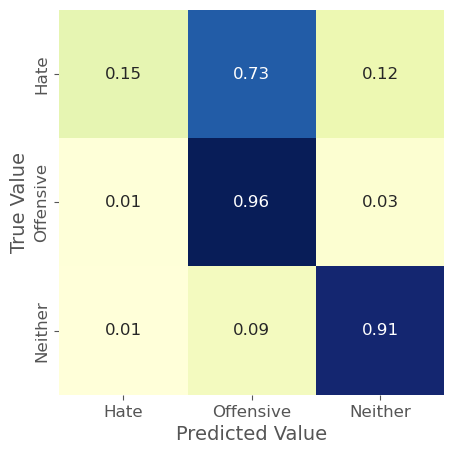

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
#NB
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2)
NB=GaussianNB()
NB.fit(X_train_tfidf,y_train)
y_preds = NB.predict(X_test_tfidf)
acc2=accuracy_score(y_test,y_preds)
precision2 = precision_score(y_test,y_preds,average='weighted')
recall2 = recall_score(y_test,y_preds, average='weighted')
f1_2 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2,"-> {:.2f}%".format(acc2*100))
print("Naive Bayes, pre Score:",precision2,"-> {:.2f}%".format(precision2*100))
print("Naive Bayes, recall Score:",recall2,"-> {:.2f}%".format(recall2*100))
print("Naive Bayes, f1-score:",f1_2,"-> {:.2f}%".format(f1_2*100))

              precision    recall  f1-score   support

           0       0.10      0.39      0.16       290
           1       0.89      0.68      0.77      3832
           2       0.54      0.58      0.56       835

    accuracy                           0.65      4957
   macro avg       0.51      0.55      0.50      4957
weighted avg       0.79      0.65      0.70      4957

Naive Bayes, Accuracy Score: 0.6491829735727255 -> 64.92%
Naive Bayes, pre Score: 0.7854670969385333 -> 78.55%
Naive Bayes, recall Score: 0.6491829735727255 -> 64.92%
Naive Bayes, f1-score: 0.7016059898186929 -> 70.16%


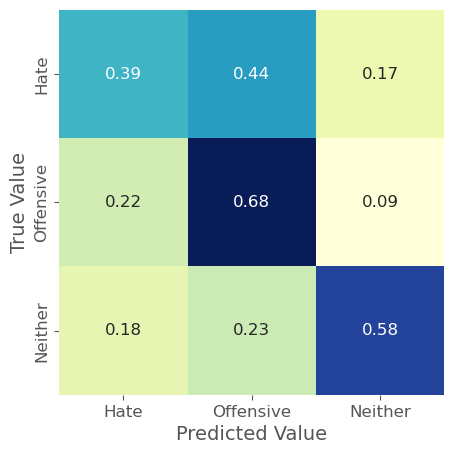

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
#SVM
support =LinearSVC(random_state=20)
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
acc3=accuracy_score(y_test,y_preds)
precision3 = precision_score(y_test,y_preds,average='weighted')
recall3 = recall_score(y_test,y_preds, average='weighted')
f13 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:",acc3,"-> {:.2f}%".format(acc3*100))
print("SVM, pre Score:",precision3,"-> {:.2f}%".format(precision3*100))
print("SVM, recall Score:",recall3,"-> {:.2f}%".format(recall3*100))
print("SVM, f1-score:",f13,"-> {:.2f}%".format(f13*100))

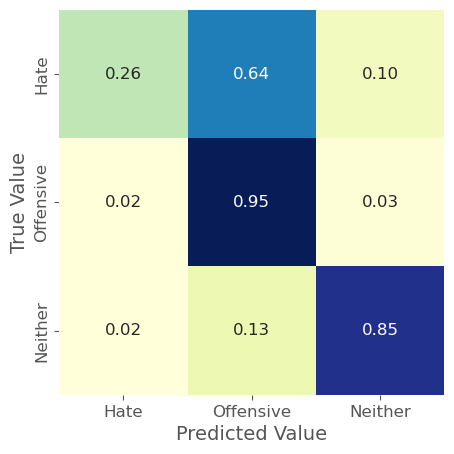

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
#DecisionTree
dt = DecisionTreeClassifier(random_state=20)
dt.fit(X_train_tfidf,y_train)
y_preds = dt.predict(X_test_tfidf)
acc4=accuracy_score(y_test,y_preds)
precision4 = precision_score(y_test,y_preds,average='weighted')
recall4 = recall_score(y_test,y_preds, average='weighted')
f14 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("DecisionTree, Accuracy Score:" , acc4,"-> {:.2f}%".format(acc4*100))
print("DecisionTree,pre Score:",precision4,"-> {:.2f}%".format(precision4*100))
print("DecisionTree,recall Score:",recall4,"-> {:.2f}%".format(recall4*100))
print("DecisionTree,f1-score:",f14,"-> {:.2f}%".format(f14*100))

              precision    recall  f1-score   support

           0       0.33      0.27      0.29       290
           1       0.93      0.93      0.93      3832
           2       0.83      0.86      0.85       835

    accuracy                           0.88      4957
   macro avg       0.69      0.69      0.69      4957
weighted avg       0.87      0.88      0.88      4957

DecisionTree, Accuracy Score: 0.8805729271736937 -> 88.06%
DecisionTree,pre Score: 0.8749770567567179 -> 87.50%
DecisionTree,recall Score: 0.8805729271736937 -> 88.06%
DecisionTree,f1-score: 0.8775633873451406 -> 87.76%


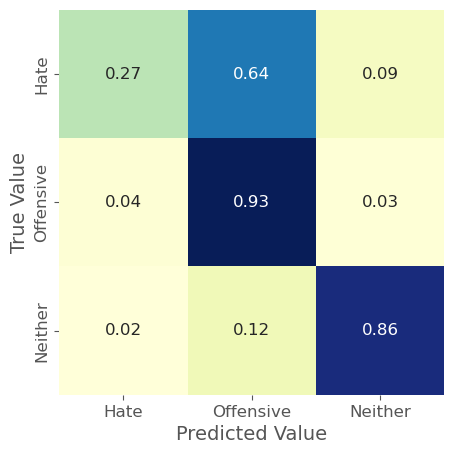

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
#Knn
knn= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )
knn.fit(X_train_tfidf,y_train)
y_preds = knn.predict(X_test_tfidf)
acc5=accuracy_score(y_test,y_preds)
precision5 = precision_score(y_test,y_preds,average='weighted')
recall5 = recall_score(y_test,y_preds, average='weighted')
f15 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("KNN, Accuracy Score:" , acc5,"-> {:.2f}%".format(acc5*100))
print("KNN,pre Score:",precision5,"-> {:.2f}%".format(precision5*100))
print("KNN,recall Score:",recall5,"-> {:.2f}%".format(recall5*100))
print("KNN,f1-score:",f15,"-> {:.2f}%".format(f15*100))

              precision    recall  f1-score   support

           0       0.26      0.15      0.19       290
           1       0.92      0.35      0.51      3832
           2       0.23      0.90      0.36       835

    accuracy                           0.43      4957
   macro avg       0.47      0.47      0.35      4957
weighted avg       0.77      0.43      0.47      4957

KNN, Accuracy Score: 0.4335283437563042 -> 43.35%
KNN,pre Score: 0.7661977396810885 -> 76.62%
KNN,recall Score: 0.4335283437563042 -> 43.35%
KNN,f1-score: 0.4672243846165548 -> 46.72%


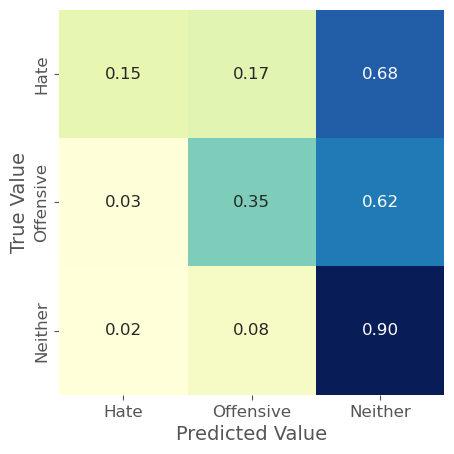

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

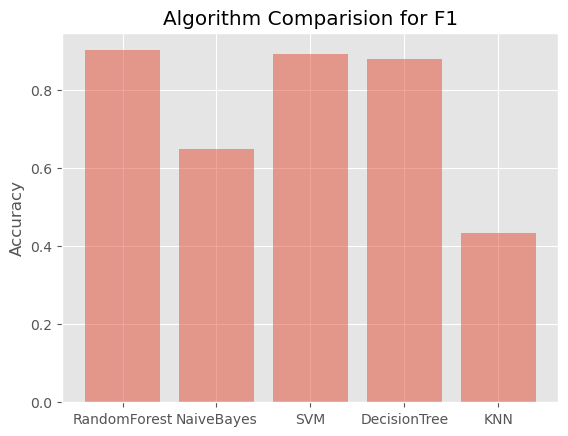

In [ ]:
objects = ('RandomForest', 'NaiveBayes', 'SVM','DecisionTree','KNN')
y_pos = np.arange(len(objects))
performance = [acc1,acc2,acc3,acc4,acc5]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for F1')
plt.show()

## Sentiment Analysis, using polarity scores as features

In [ ]:

sentiment_analyzer = VS()
def count_tags(tweet_c):

    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(tweet):
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    twitter_objs = count_tags(tweet)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(tweet)
#final_features

new_features = pd.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features

,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.000,0.120,0.880,0.4563,0.0,1.0,0.0
1,0.237,0.000,0.763,-0.6876,0.0,1.0,0.0
2,0.538,0.000,0.462,-0.9550,0.0,2.0,0.0
3,0.000,0.344,0.656,0.5673,0.0,2.0,0.0
4,0.249,0.081,0.669,-0.7762,0.0,1.0,1.0
...,...,...,...,...,...,...,...
24778,0.000,0.000,1.000,0.0000,0.0,3.0,3.0
24779,0.454,0.000,0.546,-0.8074,0.0,0.0,0.0
24780,0.000,0.219,0.781,0.4738,0.0,0.0,0.0
24781,0.573,0.000,0.427,-0.7717,0.0,0.0,0.0


In [ ]:
# F2-Conctaenation of tf-idf scores and sentiment scores
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(24783, 6448)

## Running the model Using TFIDF with some features from sentiment analysis

In [ ]:
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#RF
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1=accuracy_score(y_test,y_preds)
precision1=accuracy_score(y_test,y_preds)
recall1 = recall_score(y_test,y_preds, average='weighted')
f1 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds)
print(report)
print("Random Forest, Accuracy Score:",acc1,"-> {:.2f}%".format(acc1*100))
print("Random Forest, pre Score:",precision1,"-> {:.2f}%".format(precision1*100))
print("Random Forest, recall Score:",recall1,"-> {:.2f}%".format(recall1*100))
print("Random Forest, f1-score:",f1,"-> {:.2f}%".format(f1*100))

              precision    recall  f1-score   support

           0       0.49      0.12      0.20       290
           1       0.91      0.96      0.94      3832
           2       0.85      0.82      0.83       835

    accuracy                           0.89      4957
   macro avg       0.75      0.64      0.66      4957
weighted avg       0.87      0.89      0.88      4957

Random Forest, Accuracy Score: 0.8916683477910026 -> 89.17%
Random Forest, pre Score: 0.8916683477910026 -> 89.17%
Random Forest, recall Score: 0.8916683477910026 -> 89.17%
Random Forest, f1-score: 0.8753649322176518 -> 87.54%


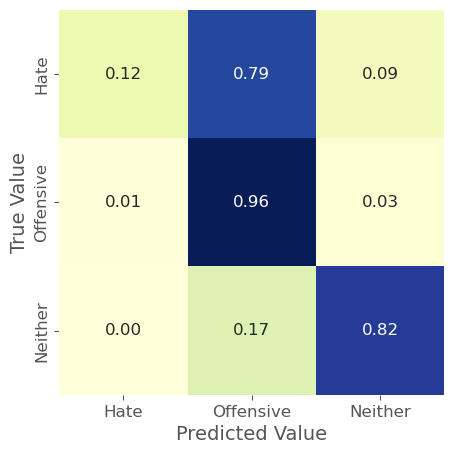

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_bow,y_train)
y_preds = nb.predict(X_test_bow)
acc2=accuracy_score(y_test,y_preds)
precision2 = precision_score(y_test,y_preds,average='weighted')
recall2 = recall_score(y_test,y_preds, average='weighted')
f1_2 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2,"-> {:.2f}%".format(acc2*100))
print("Naive Bayes, pre Score:",precision2,"-> {:.2f}%".format(precision2*100))
print("Naive Bayes, recall Score:",recall2,"-> {:.2f}%".format(recall2*100))
print("Naive Bayes, f1-score:",f1_2,"-> {:.2f}%".format(f1_2*100))

              precision    recall  f1-score   support

           0       0.10      0.39      0.16       290
           1       0.89      0.68      0.77      3832
           2       0.54      0.59      0.56       835

    accuracy                           0.65      4957
   macro avg       0.51      0.55      0.50      4957
weighted avg       0.79      0.65      0.70      4957

Naive Bayes, Accuracy Score: 0.650191648174299 -> 65.02%
Naive Bayes, pre Score: 0.786040289962654 -> 78.60%
Naive Bayes, recall Score: 0.650191648174299 -> 65.02%
Naive Bayes, f1-score: 0.7024826537103633 -> 70.25%


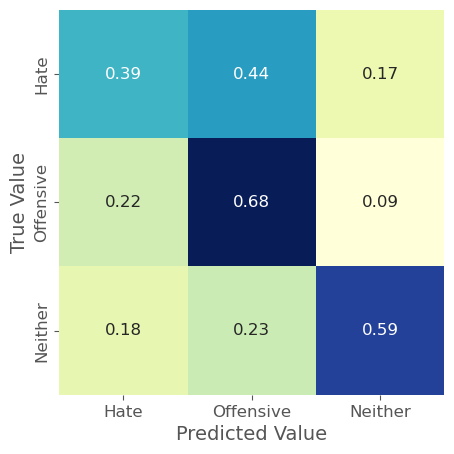

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3=accuracy_score(y_test,y_preds)
precision3 = precision_score(y_test,y_preds,average='weighted')
recall3 = recall_score(y_test,y_preds, average='weighted')
f13 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:",acc3,"-> {:.2f}%".format(acc3*100))
print("SVM, pre Score:",precision3,"-> {:.2f}%".format(precision3*100))
print("SVM, recall Score:",recall3,"-> {:.2f}%".format(recall3*100))
print("SVM, f1-score:",f13,"-> {:.2f}%".format(f13*100))

              precision    recall  f1-score   support

           0       0.46      0.26      0.33       290
           1       0.92      0.95      0.94      3832
           2       0.83      0.85      0.84       835

    accuracy                           0.89      4957
   macro avg       0.73      0.69      0.70      4957
weighted avg       0.88      0.89      0.88      4957

SVM, Accuracy Score: 0.8912648779503732 -> 89.13%
SVM, pre Score: 0.880103273784156 -> 88.01%
SVM, recall Score: 0.8912648779503732 -> 89.13%
SVM, f1-score: 0.8840184283317758 -> 88.40%


C:\Users\d\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


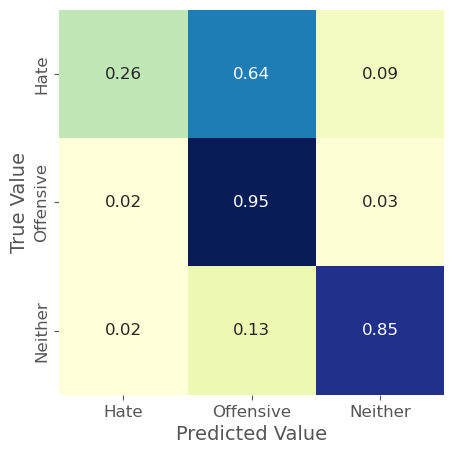

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
#DecisionTree
dt = DecisionTreeClassifier(random_state=20)
dt.fit(X_train_tfidf,y_train)
y_preds = dt.predict(X_test_tfidf)
acc4=accuracy_score(y_test,y_preds)
precision4 = precision_score(y_test,y_preds,average='weighted')
recall4 = recall_score(y_test,y_preds, average='weighted')
f14 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("DecisionTree, Accuracy Score:" , acc4,"-> {:.2f}%".format(acc4*100))
print("DecisionTree,pre Score:",precision4,"-> {:.2f}%".format(precision4*100))
print("DecisionTree,recall Score:",recall4,"-> {:.2f}%".format(recall4*100))
print("DecisionTree,f1-score:",f14,"-> {:.2f}%".format(f14*100))

              precision    recall  f1-score   support

           0       0.33      0.27      0.29       290
           1       0.93      0.93      0.93      3832
           2       0.83      0.86      0.85       835

    accuracy                           0.88      4957
   macro avg       0.69      0.69      0.69      4957
weighted avg       0.87      0.88      0.88      4957

DecisionTree, Accuracy Score: 0.8805729271736937 -> 88.06%
DecisionTree,pre Score: 0.8749770567567179 -> 87.50%
DecisionTree,recall Score: 0.8805729271736937 -> 88.06%
DecisionTree,f1-score: 0.8775633873451406 -> 87.76%


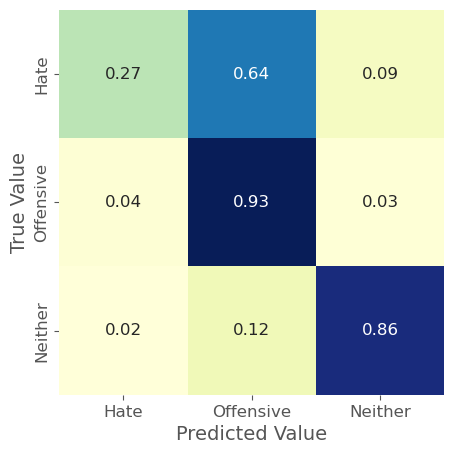

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
#Knn
knn= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )
knn.fit(X_train_tfidf,y_train)
y_preds = knn.predict(X_test_tfidf)
acc5=accuracy_score(y_test,y_preds)
precision5 = precision_score(y_test,y_preds,average='weighted')
recall5 = recall_score(y_test,y_preds, average='weighted')
f15 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("KNN, Accuracy Score:" , acc5,"-> {:.2f}%".format(acc5*100))
print("KNN,pre Score:",precision5,"-> {:.2f}%".format(precision5*100))
print("KNN,recall Score:",recall5,"-> {:.2f}%".format(recall5*100))
print("KNN,f1-score:",f15,"-> {:.2f}%".format(f15*100))

              precision    recall  f1-score   support

           0       0.26      0.15      0.19       290
           1       0.92      0.35      0.51      3832
           2       0.23      0.90      0.36       835

    accuracy                           0.43      4957
   macro avg       0.47      0.47      0.35      4957
weighted avg       0.77      0.43      0.47      4957

KNN, Accuracy Score: 0.4335283437563042 -> 43.35%
KNN,pre Score: 0.7661977396810885 -> 76.62%
KNN,recall Score: 0.4335283437563042 -> 43.35%
KNN,f1-score: 0.4672243846165548 -> 46.72%


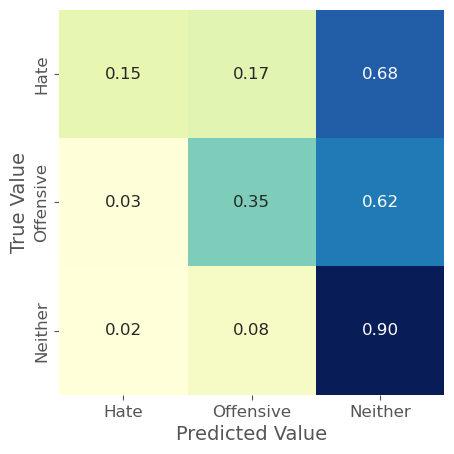

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

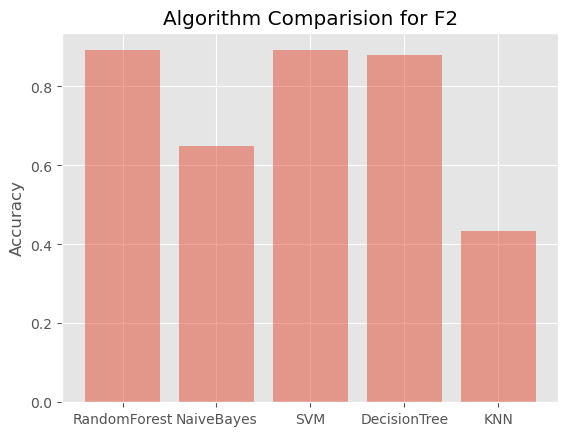

In [ ]:
objects = ('RandomForest', 'NaiveBayes', 'SVM','DecisionTree','KNN')
y_pos = np.arange(len(objects))
performance = [acc1,acc2,acc3,acc4,acc5]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for F2')
plt.show()

## Running various model Using Bag of words without additional features

In [ ]:
#bag of words-F3
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(dataset['processed_tweets'])
df_bow_sklearn = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
df_bow_sklearn.head()

,aa,aaaaaaaaand,aaahhhhh,aahahah,aaliyah,aamu,aan,aap,aaron,aaronmacgrud,...,zoom,zoot,zorro,zrgrizz,zucchini,zuko,zulema,zulu,zzzquil,zzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# If you don't specify the random_state in the code,
# then every time you run(execute) your code a new random value is generated
# and the train and test datasets would have different values each time
#bag of words without tfidf
X = df_bow_sklearn
y = dataset['class'].astype(int)
X_train_countt, X_test_countt, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

#RF
rf=RandomForestClassifier()
rf.fit(X_train_countt,y_train)
y_preds = rf.predict(X_test_countt)
acc1=accuracy_score(y_test,y_preds)
precision1=accuracy_score(y_test,y_preds)
recall1 = recall_score(y_test,y_preds, average='weighted')
f1 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds)
print(report)
print("Random Forest, Accuracy Score:",acc1,"-> {:.2f}%".format(acc1*100))
print("Random Forest, pre Score:",precision1,"-> {:.2f}%".format(precision1*100))
print("Random Forest, recall Score:",recall1,"-> {:.2f}%".format(recall1*100))
print("Random Forest, f1-score:",f1,"-> {:.2f}%".format(f1*100))

              precision    recall  f1-score   support

           0       0.47      0.29      0.36       290
           1       0.93      0.95      0.94      3832
           2       0.83      0.88      0.85       835

    accuracy                           0.90      4957
   macro avg       0.75      0.71      0.72      4957
weighted avg       0.89      0.90      0.89      4957

Random Forest, Accuracy Score: 0.8979221303207585 -> 89.79%
Random Forest, pre Score: 0.8979221303207585 -> 89.79%
Random Forest, recall Score: 0.8979221303207585 -> 89.79%
Random Forest, f1-score: 0.8918593049977546 -> 89.19%


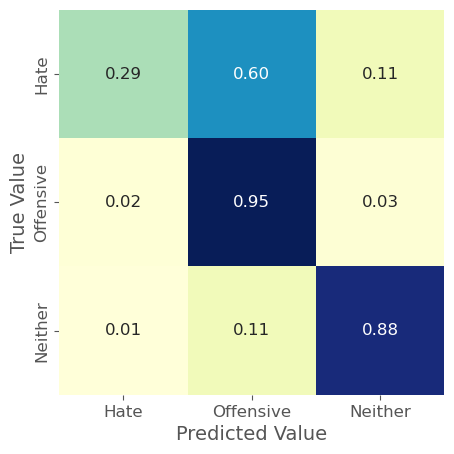

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
#NB
NB=GaussianNB()
X_train_countt, X_test_countt, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.2)
NB.fit(X_train_countt,y_train)
y_preds = NB.predict(X_test_countt)
acc2=accuracy_score(y_test,y_preds)
precision2 = precision_score(y_test,y_preds,average='weighted')
recall2 = recall_score(y_test,y_preds, average='weighted')
f1_2 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2,"-> {:.2f}%".format(acc2*100))
print("Naive Bayes, pre Score:",precision2,"-> {:.2f}%".format(precision2*100))
print("Naive Bayes, recall Score:",recall2,"-> {:.2f}%".format(recall2*100))
print("Naive Bayes, f1-score:",f1_2,"-> {:.2f}%".format(f1_2*100))

              precision    recall  f1-score   support

           0       0.07      0.44      0.12       290
           1       0.82      0.36      0.50      3832
           2       0.33      0.55      0.41       835

    accuracy                           0.40      4957
   macro avg       0.41      0.45      0.34      4957
weighted avg       0.69      0.40      0.46      4957

Naive Bayes, Accuracy Score: 0.3964091184183982 -> 39.64%
Naive Bayes, pre Score: 0.6908887026864883 -> 69.09%
Naive Bayes, recall Score: 0.3964091184183982 -> 39.64%
Naive Bayes, f1-score: 0.46210109927220494 -> 46.21%


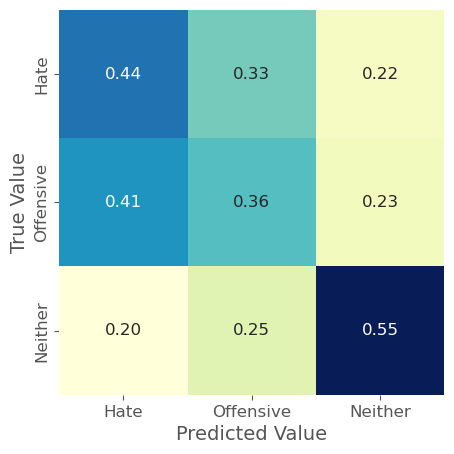

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
#SVM
support =LinearSVC(random_state=20)
support.fit(X_train_countt,y_train)
y_preds = support.predict(X_test_countt)
acc3=accuracy_score(y_test,y_preds)
precision3 = precision_score(y_test,y_preds,average='weighted')
recall3 = recall_score(y_test,y_preds, average='weighted')
f13 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:",acc3,"-> {:.2f}%".format(acc3*100))
print("SVM, pre Score:",precision3,"-> {:.2f}%".format(precision3*100))
print("SVM, recall Score:",recall3,"-> {:.2f}%".format(recall3*100))
print("SVM, f1-score:",f13,"-> {:.2f}%".format(f13*100))

C:\Users\d\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.39      0.30      0.34       290
           1       0.92      0.94      0.93      3832
           2       0.83      0.82      0.83       835

    accuracy                           0.88      4957
   macro avg       0.71      0.69      0.70      4957
weighted avg       0.88      0.88      0.88      4957

SVM, Accuracy Score: 0.8835989509784143 -> 88.36%
SVM, pre Score: 0.8764737919381078 -> 87.65%
SVM, recall Score: 0.8835989509784143 -> 88.36%
SVM, f1-score: 0.8796582116298669 -> 87.97%


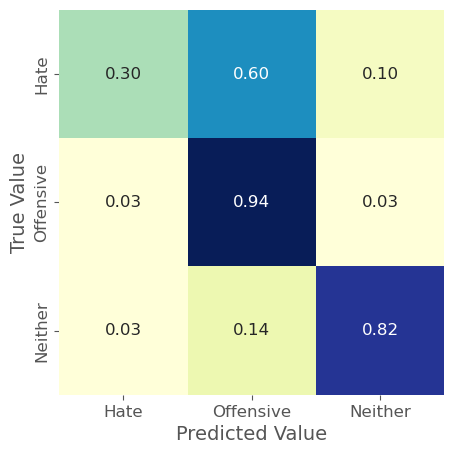

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
dt = DecisionTreeClassifier(random_state=20)
dt.fit(X_train_countt,y_train)
y_preds = dt.predict(X_test_countt)
acc4=accuracy_score(y_test,y_preds)
precision4 = precision_score(y_test,y_preds,average='weighted')
recall4 = recall_score(y_test,y_preds, average='weighted')
f14 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("DecisionTree, Accuracy Score:" , acc4,"-> {:.2f}%".format(acc4*100))
print("DecisionTree,pre Score:",precision4,"-> {:.2f}%".format(precision4*100))
print("DecisionTree,recall Score:",recall4,"-> {:.2f}%".format(recall4*100))
print("DecisionTree,f1-score:",f14,"-> {:.2f}%".format(f14*100))

              precision    recall  f1-score   support

           0       0.34      0.36      0.35       290
           1       0.94      0.93      0.93      3832
           2       0.83      0.87      0.85       835

    accuracy                           0.88      4957
   macro avg       0.70      0.72      0.71      4957
weighted avg       0.89      0.88      0.88      4957

DecisionTree, Accuracy Score: 0.8827920112971556 -> 88.28%
DecisionTree,pre Score: 0.8851239264131956 -> 88.51%
DecisionTree,recall Score: 0.8827920112971556 -> 88.28%
DecisionTree,f1-score: 0.8838739847236431 -> 88.39%


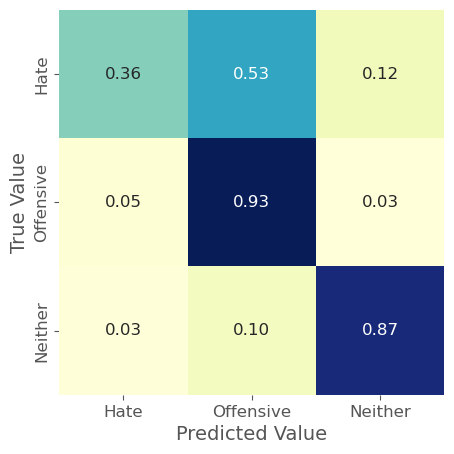

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
knn= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )
knn.fit(X_train_countt,y_train)
y_preds = knn.predict(X_test_countt)
acc5=accuracy_score(y_test,y_preds)
precision5 = precision_score(y_test,y_preds,average='weighted')
recall5 = recall_score(y_test,y_preds, average='weighted')
f15 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("KNN, Accuracy Score:" , acc5,"-> {:.2f}%".format(acc5*100))
print("KNN,pre Score:",precision5,"-> {:.2f}%".format(precision5*100))
print("KNN,recall Score:",recall5,"-> {:.2f}%".format(recall5*100))
print("KNN,f1-score:",f15,"-> {:.2f}%".format(f15*100))

              precision    recall  f1-score   support

           0       0.43      0.33      0.38       290
           1       0.89      0.94      0.91      3832
           2       0.79      0.65      0.72       835

    accuracy                           0.86      4957
   macro avg       0.71      0.64      0.67      4957
weighted avg       0.85      0.86      0.85      4957

KNN, Accuracy Score: 0.8553560621343554 -> 85.54%
KNN,pre Score: 0.8463417112394584 -> 84.63%
KNN,recall Score: 0.8553560621343554 -> 85.54%
KNN,f1-score: 0.8488525602244273 -> 84.89%


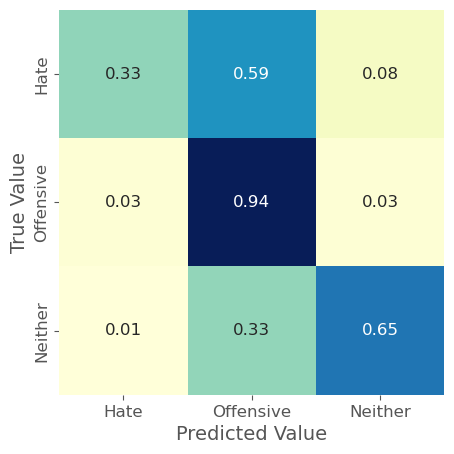

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

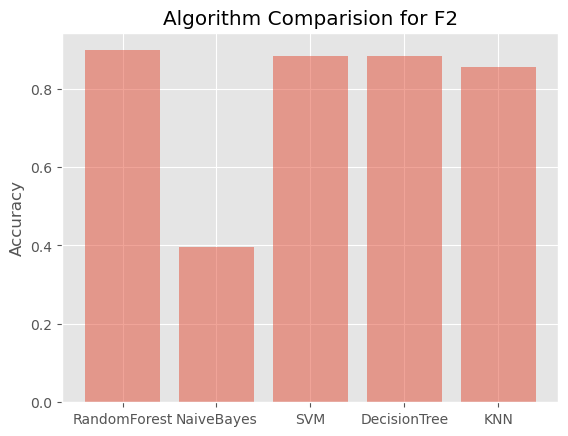

In [ ]:
objects = ('RandomForest', 'NaiveBayes', 'SVM','DecisionTree','KNN')
y_pos = np.arange(len(objects))
performance = [acc1,acc2,acc3,acc4,acc5]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for F2')
plt.show()

# Combining different features

## Running the models Using TFIDF with sentiment scores and Bow

In [ ]:
# conctaenation of tf-idf scores, sentiment scores and BOG
modelling_features = np.concatenate([tfidf_a,final_features,df_bow_sklearn],axis=1)
modelling_features.shape

(24783, 21765)

In [ ]:
#RF
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_f, X_test_f, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_f,y_train)
y_preds = rf.predict(X_test_f)
acc1=accuracy_score(y_test,y_preds)
precision1=accuracy_score(y_test,y_preds)
recall1 = recall_score(y_test,y_preds, average='weighted')
f1 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds)
print(report)
print("Random Forest, Accuracy Score:",acc1,"-> {:.2f}%".format(acc1*100))
print("Random Forest, pre Score:",precision1,"-> {:.2f}%".format(precision1*100))
print("Random Forest, recall Score:",recall1,"-> {:.2f}%".format(recall1*100))
print("Random Forest, f1-score:",f1,"-> {:.2f}%".format(f1*100))

              precision    recall  f1-score   support

           0       0.47      0.12      0.20       290
           1       0.92      0.96      0.94      3832
           2       0.84      0.87      0.86       835

    accuracy                           0.90      4957
   macro avg       0.74      0.65      0.66      4957
weighted avg       0.88      0.90      0.88      4957

Random Forest, Accuracy Score: 0.898930804922332 -> 89.89%
Random Forest, pre Score: 0.898930804922332 -> 89.89%
Random Forest, recall Score: 0.898930804922332 -> 89.89%
Random Forest, f1-score: 0.883126241670315 -> 88.31%


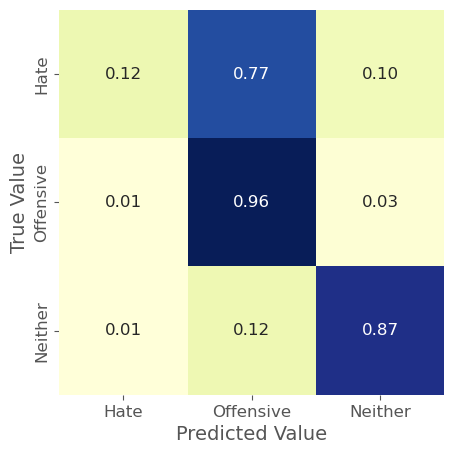

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
#NB
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_f, X_test_f, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_f,y_train)
y_preds = nb.predict(X_test_f)
acc2=accuracy_score(y_test,y_preds)
precision2 = precision_score(y_test,y_preds,average='weighted')
recall2 = recall_score(y_test,y_preds, average='weighted')
f1_2 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2,"-> {:.2f}%".format(acc2*100))
print("Naive Bayes, pre Score:",precision2,"-> {:.2f}%".format(precision2*100))
print("Naive Bayes, recall Score:",recall2,"-> {:.2f}%".format(recall2*100))
print("Naive Bayes, f1-score:",f1_2,"-> {:.2f}%".format(f1_2*100))

              precision    recall  f1-score   support

           0       0.11      0.32      0.16       290
           1       0.87      0.72      0.79      3832
           2       0.51      0.54      0.52       835

    accuracy                           0.67      4957
   macro avg       0.50      0.53      0.49      4957
weighted avg       0.77      0.67      0.71      4957

Naive Bayes, Accuracy Score: 0.6685495259229373 -> 66.85%
Naive Bayes, pre Score: 0.7651990569144275 -> 76.52%
Naive Bayes, recall Score: 0.6685495259229373 -> 66.85%
Naive Bayes, f1-score: 0.7082519109354082 -> 70.83%


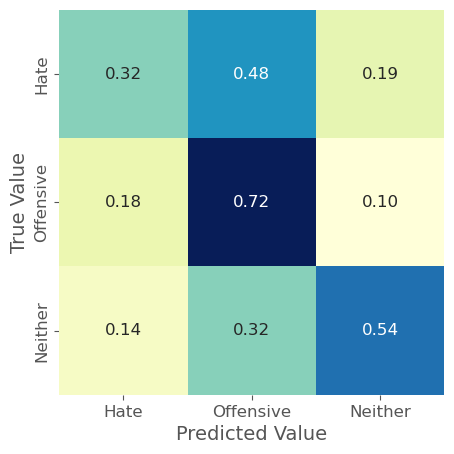

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
#svm
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_f, X_test_f, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_f,y_train)
y_preds = support.predict(X_test_f)
acc3=accuracy_score(y_test,y_preds)
precision3 = precision_score(y_test,y_preds,average='weighted')
recall3 = recall_score(y_test,y_preds, average='weighted')
f13 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:",acc3,"-> {:.2f}%".format(acc3*100))
print("SVM, pre Score:",precision3,"-> {:.2f}%".format(precision3*100))
print("SVM, recall Score:",recall3,"-> {:.2f}%".format(recall3*100))
print("SVM, f1-score:",f13,"-> {:.2f}%".format(f13*100))

C:\Users\d\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.41      0.32      0.36       290
           1       0.93      0.94      0.93      3832
           2       0.84      0.84      0.84       835

    accuracy                           0.89      4957
   macro avg       0.72      0.70      0.71      4957
weighted avg       0.88      0.89      0.88      4957

SVM, Accuracy Score: 0.8870284446237644 -> 88.70%
SVM, pre Score: 0.8806641361621471 -> 88.07%
SVM, recall Score: 0.8870284446237644 -> 88.70%
SVM, f1-score: 0.8835102867120994 -> 88.35%


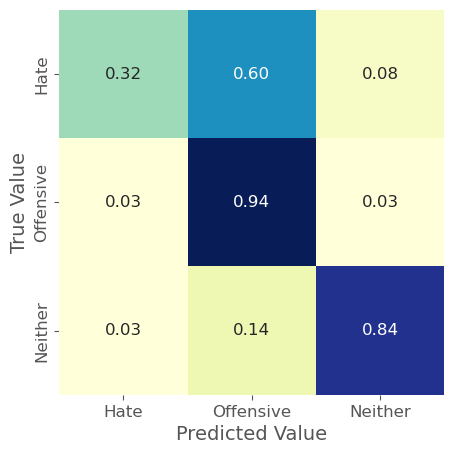

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
#DecisionTree
dt = DecisionTreeClassifier(random_state=20)
dt.fit(X_train_f,y_train)
y_preds = dt.predict(X_test_f)
acc4=accuracy_score(y_test,y_preds)
precision4 = precision_score(y_test,y_preds,average='weighted')
recall4 = recall_score(y_test,y_preds, average='weighted')
f14 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("DecisionTree, Accuracy Score:" , acc4,"-> {:.2f}%".format(acc4*100))
print("DecisionTree,pre Score:",precision4,"-> {:.2f}%".format(precision4*100))
print("DecisionTree,recall Score:",recall4,"-> {:.2f}%".format(recall4*100))
print("DecisionTree,f1-score:",f14,"-> {:.2f}%".format(f14*100))

              precision    recall  f1-score   support

           0       0.30      0.25      0.27       290
           1       0.93      0.93      0.93      3832
           2       0.82      0.84      0.83       835

    accuracy                           0.88      4957
   macro avg       0.68      0.67      0.68      4957
weighted avg       0.87      0.88      0.87      4957

DecisionTree, Accuracy Score: 0.8775469033689731 -> 87.75%
DecisionTree,pre Score: 0.8719272164578411 -> 87.19%
DecisionTree,recall Score: 0.8775469033689731 -> 87.75%
DecisionTree,f1-score: 0.8745879591161027 -> 87.46%


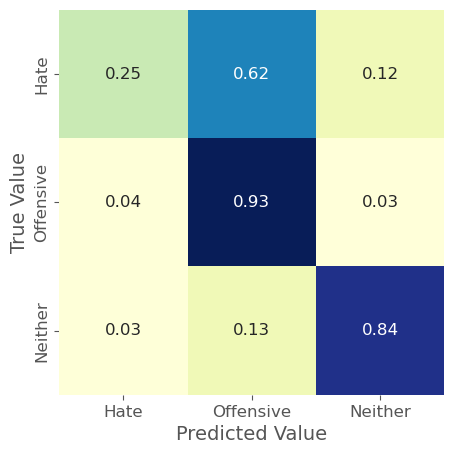

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
#Knn
knn= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )
knn.fit(X_train_f,y_train)
y_preds = knn.predict(X_test_f)
acc5=accuracy_score(y_test,y_preds)
precision5 = precision_score(y_test,y_preds,average='weighted')
recall5 = recall_score(y_test,y_preds, average='weighted')
f15 = f1_score(y_test,y_preds, average='weighted')
report = classification_report( y_test, y_preds )
print(report)
print("KNN, Accuracy Score:" , acc5,"-> {:.2f}%".format(acc5*100))
print("KNN,pre Score:",precision5,"-> {:.2f}%".format(precision5*100))
print("KNN,recall Score:",recall5,"-> {:.2f}%".format(recall5*100))
print("KNN,f1-score:",f15,"-> {:.2f}%".format(f15*100))

              precision    recall  f1-score   support

           0       0.43      0.31      0.36       290
           1       0.88      0.94      0.91      3832
           2       0.78      0.61      0.69       835

    accuracy                           0.85      4957
   macro avg       0.70      0.62      0.65      4957
weighted avg       0.84      0.85      0.84      4957

KNN, Accuracy Score: 0.8507161589671172 -> 85.07%
KNN,pre Score: 0.8397707200491545 -> 83.98%
KNN,recall Score: 0.8507161589671172 -> 85.07%
KNN,f1-score: 0.8421554873101151 -> 84.22%


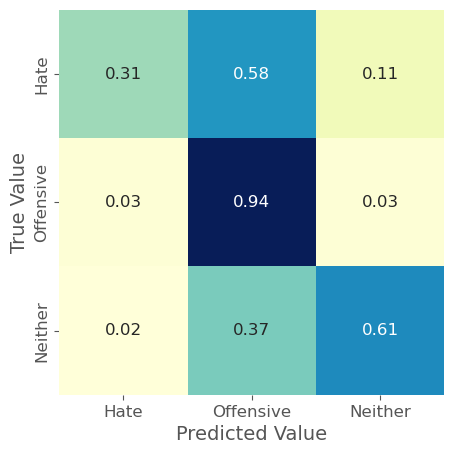

In [ ]:
cm = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = cm[i,:]/float(cm[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

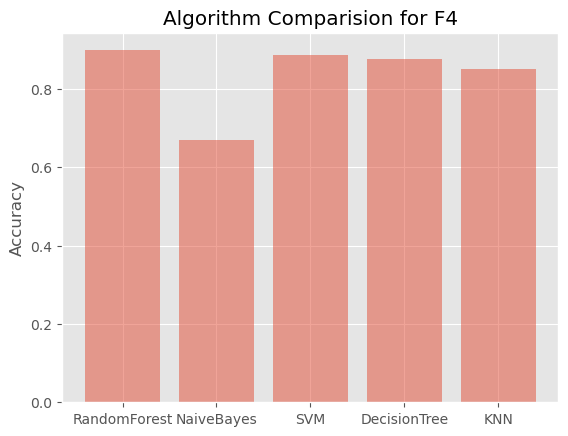

In [ ]:
objects = ('RandomForest', 'NaiveBayes', 'SVM','DecisionTree','KNN')
y_pos = np.arange(len(objects))
performance = [acc1,acc2,acc3,acc4,acc5]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for F4')
plt.show()